In [70]:
import pandas as pd
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

In [71]:
pd.set_option('display.max_colwidth', 2000)
df = pd.read_csv("data.csv", names=['p_data'])
df.head(2)

,p_data
0,"COMPUTER TERMINAL SYSTEMS & lt ; CPML > COMPLETES SALE Computer Terminal Systems Inc said it has completed the sale of 200 , 000 shares of its common stock , and warrants to acquire an additional one mln shares , to & lt ; Sedio N . V .> of Lugano , Switzerland for 50 , 000 dlrs . The company said the warrants are exercisable for five years at a purchase price of . 125 dlrs per share . Computer Terminal said Sedio also has the right to buy additional shares and increase its total holdings up to 40 pct of the Computer Terminal ' s outstanding common stock under certain circumstances involving change of control at the company . The company said if the conditions occur the warrants would be exercisable at a price equal to 75 pct of its common stock ' s market price at the time , not to exceed 1 . 50 dlrs per share . Computer Terminal also said it sold the technolgy rights to its Dot Matrix impact technology , including any future improvements , to & lt ; Woodco Inc > of Houston , Tex . for 200 , 000 dlrs . But , it said it would continue to be the exclusive worldwide licensee of the technology for Woodco . The company said the moves were part of its reorganization plan and would help pay current operation costs and ensure product delivery . Computer Terminal makes computer generated labels , forms , tags and ticket printers and terminals ."
1,NATIONAL AMUSEMENTS AGAIN UPS VIACOM & lt ; VIA > BID Viacom International Inc said & lt ; National Amusements Inc > has again raised the value of its offer for Viacom ' s publicly held stock . The company said the special committee of its board plans to meet later today to consider this offer and the one submitted March one by & lt ; MCV Holdings Inc >. A spokeswoman was unable to say if the committee met as planned yesterday . Viacom said National Amusements ' Arsenal Holdings Inc subsidiary has raised the amount of cash it is offering for each Viacom share by 75 cts to 42 . 75 dlrs while the value of the fraction of a share of exchangeable Arsenal Holdings preferred to be included was raised 25 cts to 7 . 75 dlrs . National Amusements already owns 19 . 6 pct of Viacom ' s stock .


# 1. Text pre-processing 

This is the process of cleaning the data that makes the processed data suitable for easier feature construction.

Text pre-processing involves following steps:

    1. Converting text into lower case
    
    2. Removal of punctuations, symbols
    
    3. Removal of stop words
    
    4. Removal of special characters and numbers
    
    5. Removal of extra space
    
    6. Stemming and lemmatization  (However we will only perform lemmatization, as this is more useful in this scenario) 

# 2. Text pre-processing (implementation)

In [72]:
#Converting text into lower case
df['p_data'] = df['p_data'].str.lower()                                 


 # Removal of punctuations, symbols
string.punctuation
def remove_punctuations(text):                                         
    punctuations = string.punctuation
    return text.translate(str.maketrans('', '', punctuations))
df['p_data'] = df['p_data'].apply(lambda x: remove_punctuations(x))


# Removal of stop words
", ".join(stopwords.words('english'))                                     
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in STOPWORDS])
df['p_data'] = df['p_data'].apply(lambda x: remove_stopwords(x))


# Removal of special characters and numbers
def remove_spl_chars(text):
    text = re.sub('[^a-zA-Z]', ' ', text)                                
    text = re.sub('\s+', ' ', text)
    return text
df['p_data'] = df['p_data'].apply(lambda x: remove_spl_chars(x))


#Removal of extra space
df["p_data"] = df["p_data"].apply(lambda x: re.sub(' +', ' ', x))                                


#Lemmatization
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V": wordnet.VERB, "J": wordnet.ADJ, "R": wordnet.ADV}
def lemmatize_words(text):
    # find pos tags
    pos_text = pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_text])
wordnet.NOUN
df['p_data'] = df['p_data'].apply(lambda x: lemmatize_words(x))
df.head(2)

,p_data
0,computer terminal system lt cpml completes sale computer terminal system inc say complete sale share common stock warrant acquire additional one mln share lt sedio n v lugano switzerland dlrs company say warrant exercisable five year purchase price dlrs per share computer terminal say sedio also right buy additional share increase total holding pct computer terminal outstanding common stock certain circumstance involve change control company company say condition occur warrant would exercisable price equal pct common stock market price time exceed dlrs per share computer terminal also say sell technolgy right dot matrix impact technology include future improvement lt woodco inc houston tex dlrs say would continue exclusive worldwide licensee technology woodco company say move part reorganization plan would help pay current operation cost ensure product delivery computer terminal make computer generate label form tag ticket printer terminal
1,national amusement ups viacom lt via bid viacom international inc say lt national amusement inc raise value offer viacom publicly hold stock company say special committee board plan meet later today consider offer one submit march one lt mcv holding inc spokeswoman unable say committee meet plan yesterday viacom say national amusement arsenal holding inc subsidiary raise amount cash offering viacom share cts dlrs value fraction share exchangeable arsenal holding prefer include raise ct dlrs national amusement already own pct viacom stock


### Some other processing using Pyspark

In [73]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark

In [74]:
sentenceData =  spark.createDataFrame(df)
sentenceData.show()

+--------------------+
|              p_data|
+--------------------+
|computer terminal...|
|national amusemen...|
|u k grow impatien...|
|gould lt gld comp...|
|first wisconsin l...|
|lt meridian energ...|
|feed heller urge ...|
|gould lt gld sell...|
|fidelity lt fnf u...|
|bp manage directo...|
|security lt spc u...|
|dennison manufact...|
|pillsbury lt psy ...|
|bp lt bp plan hik...|
|louisiana pacific...|
|suburban bancorp ...|
|fair lane lt fair...|
|cb lt cbtb make a...|
|usx lt x say talk...|
|first financial l...|
+--------------------+
only showing top 20 rows



#### Tokenization, TF-IDF Vectorization

In [97]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
tokenizer = Tokenizer(inputCol="p_data", outputCol="words")
wordsData = tokenizer.transform(sentenceData)

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=20)
featurizedData = hashingTF.transform(wordsData)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)
rescaledData.select("features").show()

+--------------------+
|            features|
+--------------------+
|(20,[0,1,2,3,4,5,...|
|(20,[0,1,2,3,4,6,...|
|(20,[1,2,3,4,5,6,...|
|(20,[0,2,3,4,5,6,...|
|(20,[0,2,3,4,5,7,...|
|(20,[1,2,3,4,6,7,...|
|(20,[0,1,2,3,4,5,...|
|(20,[0,2,4,5,6,7,...|
|(20,[1,2,3,4,5,7,...|
|(20,[2,3,7,11,13,...|
|(20,[0,1,2,3,4,5,...|
|(20,[0,1,2,3,4,5,...|
|(20,[0,1,2,3,4,5,...|
|(20,[0,1,2,3,4,5,...|
|(20,[0,1,2,3,5,7,...|
|(20,[2,3,4,6,9,10...|
|(20,[0,2,4,6,7,8,...|
|(20,[0,2,4,5,8,9,...|
|(20,[0,1,2,3,4,5,...|
|(20,[0,1,2,3,5,6,...|
+--------------------+
only showing top 20 rows



# 3. Spliting data randomly into train and test

In [98]:
train, test = rescaledData.randomSplit([0.8,0.2])
print("No. of rows in train dataset:", (train.count()))
print("No. of rows in test dataset:", (test.count()))

No. of rows in train dataset: 260
No. of rows in test dataset: 71


# 4. Using training dataset to tune the hyper-parameters of the k-means algorithm

In [158]:
from pyspark.ml.clustering import KMeans
kmeans = KMeans(k=2)
model = kmeans.fit(train.select('features'))
transformed = model.transform(train)
prediction1= transformed.select("features","prediction")
prediction1.show()

#prediction column tell about the cluster i.e., most words in equivalent row(features) goes to that specific cluster 

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|(20,[0,1,2,3,4,5,...|         0|
|(20,[0,1,2,3,5,9,...|         0|
|(20,[0,1,2,3,4,5,...|         0|
|(20,[0,1,2,3,4,5,...|         1|
|(20,[0,1,2,3,4,5,...|         1|
|(20,[0,2,3,4,5,6,...|         0|
|(20,[0,1,2,3,4,5,...|         0|
|(20,[2,3,4,5,6,7,...|         0|
|(20,[0,2,4,6,7,8,...|         0|
|(20,[0,1,2,3,4,5,...|         0|
|(20,[1,2,3,4,5,7,...|         0|
|(20,[0,1,2,3,5,6,...|         0|
|(20,[0,2,3,4,5,7,...|         0|
|(20,[0,2,3,4,5,6,...|         0|
|(20,[0,1,2,3,4,5,...|         0|
|(20,[0,2,4,5,6,7,...|         0|
|(20,[0,1,2,3,5,6,...|         0|
|(20,[0,1,2,3,4,5,...|         1|
|(20,[0,1,2,4,5,6,...|         0|
|(20,[0,1,2,3,5,7,...|         0|
+--------------------+----------+
only showing top 20 rows



In [162]:
kmeans2 = KMeans(k=3)
model2 = kmeans2.fit(train.select('features'))
transformed2 = model2.transform(train)
prediction2= transformed2.select("features","prediction")
prediction2.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|(20,[0,1,2,3,4,5,...|         0|
|(20,[0,1,2,3,5,9,...|         0|
|(20,[0,1,2,3,4,5,...|         0|
|(20,[0,1,2,3,4,5,...|         2|
|(20,[0,1,2,3,4,5,...|         2|
|(20,[0,2,3,4,5,6,...|         0|
|(20,[0,1,2,3,4,5,...|         0|
|(20,[2,3,4,5,6,7,...|         0|
|(20,[0,2,4,6,7,8,...|         0|
|(20,[0,1,2,3,4,5,...|         0|
|(20,[1,2,3,4,5,7,...|         0|
|(20,[0,1,2,3,5,6,...|         0|
|(20,[0,2,3,4,5,7,...|         0|
|(20,[0,2,3,4,5,6,...|         0|
|(20,[0,1,2,3,4,5,...|         0|
|(20,[0,2,4,5,6,7,...|         0|
|(20,[0,1,2,3,5,6,...|         0|
|(20,[0,1,2,3,4,5,...|         2|
|(20,[0,1,2,4,5,6,...|         0|
|(20,[0,1,2,3,5,7,...|         0|
+--------------------+----------+
only showing top 20 rows



In [159]:
kmeans3 = KMeans(k=4)
model3 = kmeans3.fit(train.select('features'))
transformed3 = model3.transform(train)
prediction3= transformed3.select("features","prediction")
prediction3.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|(20,[0,1,2,3,4,5,...|         0|
|(20,[0,1,2,3,5,9,...|         1|
|(20,[0,1,2,3,4,5,...|         0|
|(20,[0,1,2,3,4,5,...|         3|
|(20,[0,1,2,3,4,5,...|         3|
|(20,[0,2,3,4,5,6,...|         1|
|(20,[0,1,2,3,4,5,...|         0|
|(20,[2,3,4,5,6,7,...|         1|
|(20,[0,2,4,6,7,8,...|         1|
|(20,[0,1,2,3,4,5,...|         0|
|(20,[1,2,3,4,5,7,...|         1|
|(20,[0,1,2,3,5,6,...|         1|
|(20,[0,2,3,4,5,7,...|         1|
|(20,[0,2,3,4,5,6,...|         1|
|(20,[0,1,2,3,4,5,...|         0|
|(20,[0,2,4,5,6,7,...|         1|
|(20,[0,1,2,3,5,6,...|         1|
|(20,[0,1,2,3,4,5,...|         2|
|(20,[0,1,2,4,5,6,...|         1|
|(20,[0,1,2,3,5,7,...|         1|
+--------------------+----------+
only showing top 20 rows



# 5. Apply the k-means algorithm using the winning hyper-parameter values to the test data

In [163]:
# k=2
transformed_test = model.transform(test)
pre1= transformed.select("features","prediction")
pre1.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|(20,[0,1,2,3,4,5,...|         0|
|(20,[0,1,2,3,5,9,...|         0|
|(20,[0,1,2,3,4,5,...|         0|
|(20,[0,1,2,3,4,5,...|         1|
|(20,[0,1,2,3,4,5,...|         1|
|(20,[0,2,3,4,5,6,...|         0|
|(20,[0,1,2,3,4,5,...|         0|
|(20,[2,3,4,5,6,7,...|         0|
|(20,[0,2,4,6,7,8,...|         0|
|(20,[0,1,2,3,4,5,...|         0|
|(20,[1,2,3,4,5,7,...|         0|
|(20,[0,1,2,3,5,6,...|         0|
|(20,[0,2,3,4,5,7,...|         0|
|(20,[0,2,3,4,5,6,...|         0|
|(20,[0,1,2,3,4,5,...|         0|
|(20,[0,2,4,5,6,7,...|         0|
|(20,[0,1,2,3,5,6,...|         0|
|(20,[0,1,2,3,4,5,...|         1|
|(20,[0,1,2,4,5,6,...|         0|
|(20,[0,1,2,3,5,7,...|         0|
+--------------------+----------+
only showing top 20 rows



In [164]:
# k=3
transformed_test2 = model2.transform(test)
pre2= transformed_test2.select("features","prediction")
pre2.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|(20,[2,3,7,11,13,...|         0|
|(20,[0,1,2,3,4,5,...|         2|
|(20,[0,2,4,5,8,9,...|         0|
|(20,[0,1,2,3,4,5,...|         0|
|(20,[0,1,2,3,4,5,...|         0|
|(20,[0,1,2,3,4,5,...|         2|
|(20,[0,2,4,5,6,7,...|         0|
|(20,[0,1,2,3,4,5,...|         0|
|(20,[0,1,2,3,4,5,...|         0|
|(20,[0,1,2,3,4,5,...|         0|
|(20,[0,1,2,4,5,6,...|         0|
|(20,[0,1,2,3,4,5,...|         0|
|(20,[0,2,4,5,7,8,...|         0|
|(20,[0,1,2,3,4,6,...|         0|
|(20,[0,1,2,3,4,5,...|         0|
|(20,[0,5,7,8,9,11...|         0|
|(20,[0,1,2,3,4,5,...|         2|
|(20,[0,1,2,3,4,5,...|         0|
|(20,[0,1,2,4,5,6,...|         0|
|(20,[0,1,2,3,5,11...|         0|
+--------------------+----------+
only showing top 20 rows



In [165]:
# k=4
transformed_test3 = model3.transform(test)
pre3= transformed_test3.select("features","prediction")
pre3.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|(20,[2,3,7,11,13,...|         1|
|(20,[0,1,2,3,4,5,...|         0|
|(20,[0,2,4,5,8,9,...|         1|
|(20,[0,1,2,3,4,5,...|         1|
|(20,[0,1,2,3,4,5,...|         1|
|(20,[0,1,2,3,4,5,...|         0|
|(20,[0,2,4,5,6,7,...|         1|
|(20,[0,1,2,3,4,5,...|         1|
|(20,[0,1,2,3,4,5,...|         1|
|(20,[0,1,2,3,4,5,...|         0|
|(20,[0,1,2,4,5,6,...|         0|
|(20,[0,1,2,3,4,5,...|         1|
|(20,[0,2,4,5,7,8,...|         1|
|(20,[0,1,2,3,4,6,...|         1|
|(20,[0,1,2,3,4,5,...|         1|
|(20,[0,5,7,8,9,11...|         1|
|(20,[0,1,2,3,4,5,...|         2|
|(20,[0,1,2,3,4,5,...|         1|
|(20,[0,1,2,4,5,6,...|         1|
|(20,[0,1,2,3,5,11...|         1|
+--------------------+----------+
only showing top 20 rows



# 6. Propose and implement an approach to evaluate the performance of your algorithm on the test data.

In [175]:
from pyspark.ml.evaluation import Evaluator

In [176]:
evaluator.evaluate(transformed_test)

0.8476984829284918

In [177]:
evaluator.evaluate(transformed_test2)

0.8476984829284918

In [178]:
evaluator.evaluate(transformed_test3)

0.5305615962450296

In [ ]:
# model 1 (where k=2) and model 2 (where k=3) have good evaluation score whereas model 3 (where k=4) is bad as per evaluation

# 7. For each cluster, report the top frequent words

C:\Users\pargat\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


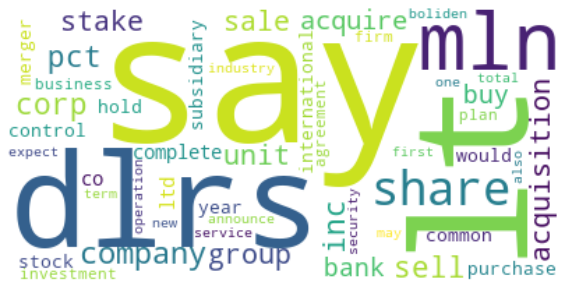

In [79]:
from collections import Counter

my_list= df['p_data'].values.tolist()
joined_list= " ".join(my_list)

result= Counter(joined_list.split(" "))

from sklearn.feature_extraction.text import TfidfVectorizer
v= TfidfVectorizer()
x= v.fit_transform(df['p_data'])
df_tfidf= pd.DataFrame(x.todense())

feature_names= v.get_feature_names()
dense= x.todense()
lst1= dense.tolist()
df_tfidf= pd.DataFrame(lst1, columns=feature_names)

from sklearn.model_selection import train_test_split
df_tfidf_train, df_tfidf_test = train_test_split(df_tfidf, test_size=0.20)

from sklearn.cluster import KMeans

kmeans= KMeans(n_clusters=2).fit(df_tfidf_train)                 #considering only two clusters
labels= KMeans(n_clusters=2).fit_predict(df_tfidf_train)

import matplotlib.pyplot as plt
from wordcloud import WordCloud

c1= df_tfidf_train[labels== 0]

c2= df_tfidf_train[labels== 1]

Cloud= WordCloud(background_color="white",max_words=50).generate_from_frequencies(c1.T.sum(axis=1))
plt.figure(figsize=(10,10))
plt.imshow(Cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

 Cluster 1 contains words related to Finance/business

  Top frequent words(that are shown in bigger size in plot) are:
    
    say
    
    Dlrs (dollars)
    
    mln ( million)
    
    lt 
    
    stake
    
    corp (corporation)
    
    bank
    
    sale
    
    sell
    
    company
    
    group

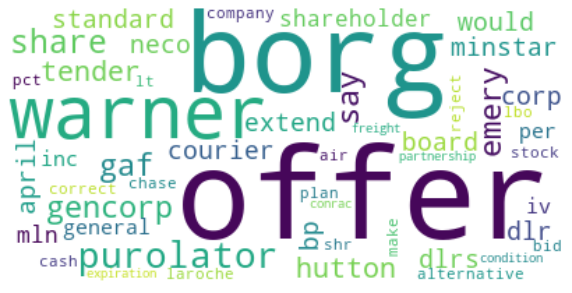

In [80]:
Cloud= WordCloud(background_color="white",max_words=50).generate_from_frequencies(c2.T.sum(axis=1))
plt.figure(figsize=(10,10))
plt.imshow(Cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Cluster 2 contains words related to names

Top frequent words are:

    offer
    
    warner
    
    borg
    
    purolator
    
    gencorp
    
    minstar
    
    april
    
    gaf

#### - Pargat Singh
